In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 800)

import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend

import datetime as dt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# Modules

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 800)

import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend

import datetime as dt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The KPN Group sells its products through different channels. 
* online 
* telephone 
* retail stores
* third-party stores. 

The KPN formula in the streets:
* KPN shop -- only KPN
* Telfort shop (KPN subsidiary) -- only Telfort
* Multibrand store -- combines the brands KPN, Telfort and XS4ALL,
* KPN XL store -- combines the consumer and small business segments.

## Research questions:
1. Which characteristics are most important for predicting the (contracted)
revenue per store formula (Telfort, KPN, KPN XL)?
2. Which Telfort stores should be transformed into KPN stores, and what is
the expected (contracted) revenue after this transformation?
3. Our budget enables the transformation of 5 KPN stores into KPN XL stores.
Which KPN stores should we transform to optimize the revenue?
4. Possibly continue with remaining questions to complete this advice.

## Evaluation
We find it more important that you are able to communicate and defend your advice well, than that you build the most advanced model. Therefore you should think about the complexity of the solution you choose in order to explain your decisions to an audience without explicit data science background. We do value a solid reasoning behind the chosen data transformations, etc.

Please send the two files before noon the day prior to the walkthrough and presentation sessions to Tom

## Case

In [ ]:
case = pd.read_csv('dataset_shops.csv',
                   usecols = ['date', 'shop_id', 'committed_revenues_main_inc_vat', 'place', 
                              'shop_formula', 'dist_shop_closest_km', 'no_retail_shops', 
                              'no_companies', 'perc_owned_vs_rented_houses', 
                              'avg_value_household', 'avg_household_size', 'no_residents'])

# Other columns: tons of NA, not particularly relevant to question of interest (at first pass anyway)

case.date = pd.to_datetime(case.date)


In [ ]:
for c in case.columns:
    if type(case[c][0]) != np.float64:
        print(c, len(case[c].unique()))

In [ ]:
# NA EDA

for c in [case.columns]:
    print(case[c].isna().sum())

c_subset = case[pd.isnull(case).any(axis=1)].copy()

for c in ['shop_id', 'place', 'shop_formula']:
    print(c, c_subset[c].unique())

## KPN

In [ ]:
kpn = case[case.shop_formula == 'KPN winkel']

In [ ]:
# Shops per place --> only 7 place with > 1 shops

(kpn[['place', 'shop_id']].
 drop_duplicates().
 groupby('place')['shop_id'].
 count().
 sort_values(ascending = False)
)



In [ ]:
# Aggregate to weekly
kpn_monthly = (kpn[['date', 'shop_id', 'committed_revenues_main_inc_vat', 'place']].
              set_index('date').
              groupby(['place', 'shop_id']).
              resample('M').sum().reset_index().copy())


# Plot a few for EDA
# plt.rcParams["figure.figsize"] = [20, 5]
# places = np.random.choice(kpn.shop_id.unique(), size = 5, replace = False)


# kpn_monthly_mini = kpn_monthly[kpn_monthly.shop_id.isin([places])]
# kpn_monthly_mini = kpn_monthly[kpn_monthly.place == 'amsterdam']

# kpn_plot = kpn_monthly_mini.pivot(index = 'date', columns = 'shop_id', values='committed_revenues_main_inc_vat')
# kpn_plot.plot()

In [ ]:
kpn_monthly = (kpn[['date', 'shop_id', 'committed_revenues_main_inc_vat', 'place']].
              set_index('date').
              groupby(['place', 'shop_id']).
              resample('M').sum().reset_index().copy())

# No time-varying covariates, so weekly observation completely unnecessary/incorrect (wildly violates linear regression assumptions) 
# Don’t want to penalize stores for shorter timelines or missing weeks, so weekly avg.

kpn2 = pd.merge(
    pd.DataFrame(kpn.groupby(['shop_id'])['committed_revenues_main_inc_vat'].mean().round().reset_index()),
    kpn[['shop_id', 'place', 'dist_shop_closest_km', 'no_retail_shops',
       'no_companies', 'perc_owned_vs_rented_houses', 'avg_value_household',
       'avg_household_size', 'no_residents']].drop_duplicates()
).dropna()

# kpn2[pd.isnull(kpn2).any(axis=1)]


In [ ]:
plt.scatter(x = kpn2.no_residents, y = kpn2.committed_revenues_main_inc_vat)

# (1) NOTHING: perc_owned_vs_rented_houses, avg_household_size, avg_value_household
# (2) PATTERN: no_residents, no_retail_shops, no_companies
# (3) UNCLEAR: 'dist_shop_closest_km',

# Make indicator w/ interaction, or quadratic

## Quadratic

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import r2_score

0.26

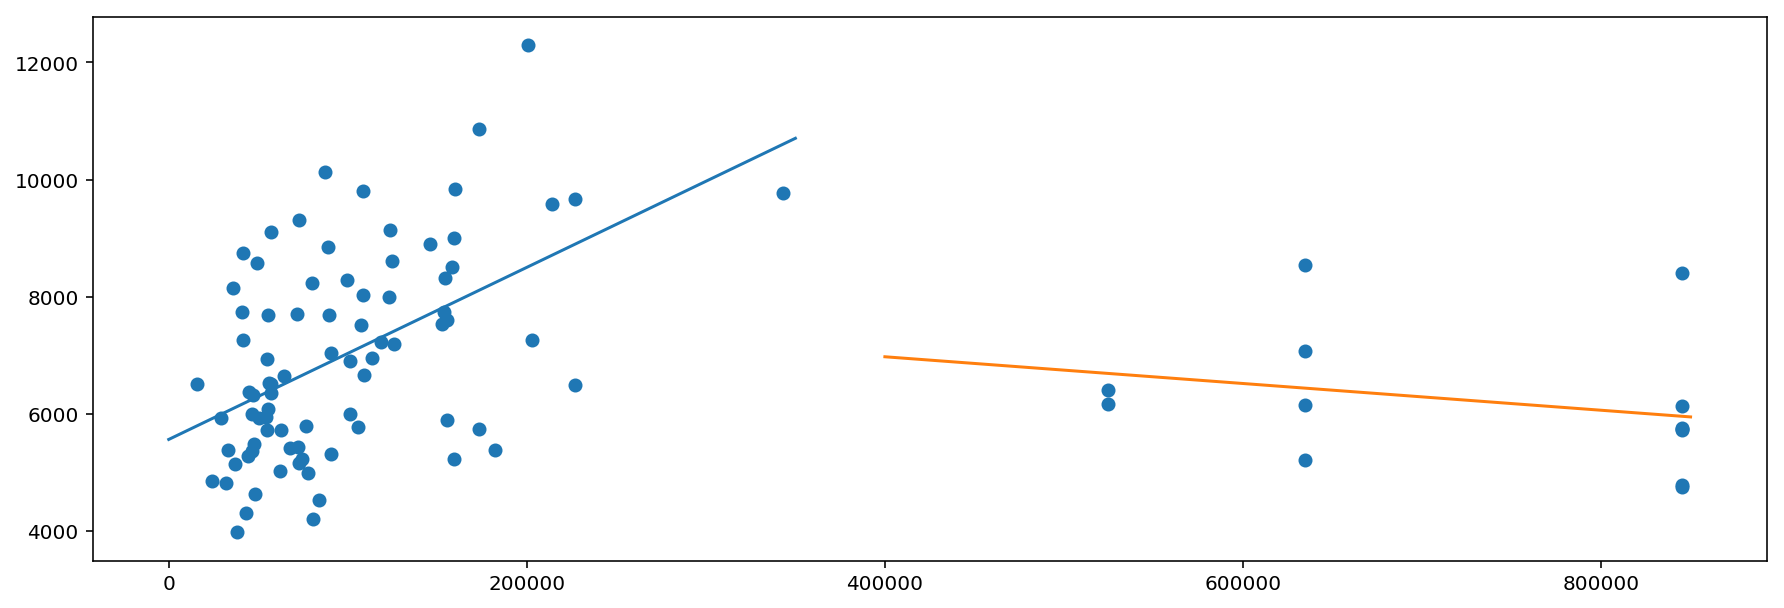

In [158]:
# --- Just no_residents ---

# Quadratic
# kpn2.loc[:,'no_residents2'] = kpn2.no_residents**2
# X = kpn2[['no_residents', 'no_residents2']] 
# X = sm.add_constant(X)


# Indicators
kpn2.loc[:,'no_residents_lt'] = np.where(kpn2.no_residents < 400000, kpn2.no_residents, 0)
kpn2.loc[:,'no_residents_gt'] = np.where(kpn2.no_residents > 400000, kpn2.no_residents, 0)
kpn2.loc[:, 'c_lt'] = (kpn2['no_residents_lt'] != 0)*1
kpn2.loc[:, 'c_gt'] = (kpn2['no_residents_gt'] != 0)*1
X = kpn2[['c_lt', 'no_residents_lt', 'c_gt', 'no_residents_gt']]


y = kpn2['committed_revenues_main_inc_vat']




# Regression
mod = sm.OLS(y, X, missing='drop').fit()
mod.rsquared.round(2)


# ------------------------------

plt.rcParams["figure.figsize"] = [15, 5]

# Quadratic Regression plot
# x1 = np.arange(1, 900000, 50000)
# x = pd.DataFrame(data = {'int': 1, 'no_res': x1, 'no_res2': x1**2})
# plt.plot(x1, mod.predict(x))


# Indicator Regression Plot
x_lt = np.arange(1, 400000, 50000)
plt.plot(x_lt, mod.predict(pd.DataFrame(data = {'c_lt': 1, 'no_res_lt': x_lt, 'c_gt': 0, 'no_res_gt': 0})))
x_gt = np.arange(400000, 900000, 50000)
plt.plot(x_gt, mod.predict(pd.DataFrame(data = {'c_lt': 0, 'no_res_lt': 0,    'c_gt': 1, 'no_res_gt': x_gt})))


# Empirical Plot
plt.scatter(kpn2.no_residents, kpn2.committed_revenues_main_inc_vat)



# Indicator R^2: 0.26
# Quadratic R^2: 0.18

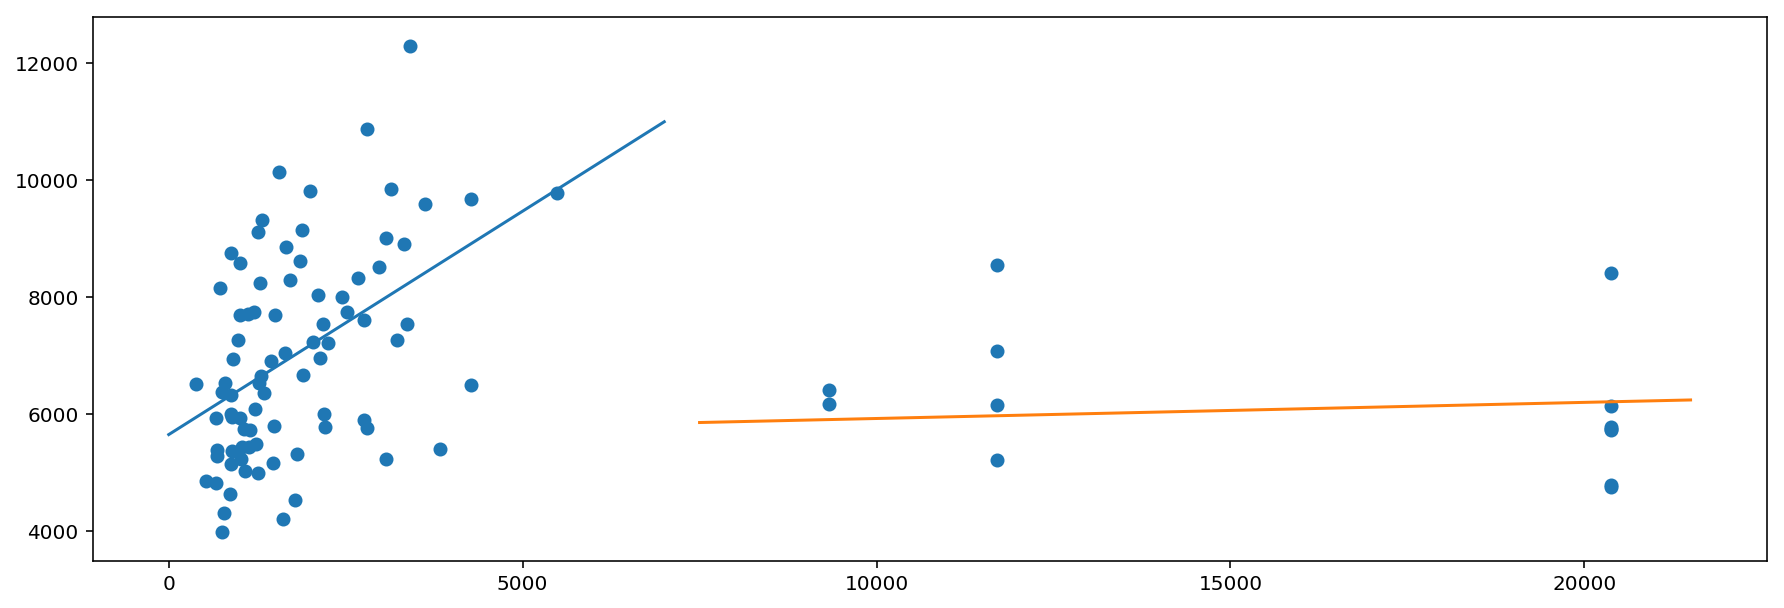

In [144]:
# --- Just no_retail_shops ---
# kpn2.loc[:,'no_retail_shops2'] = kpn2.no_retail_shops**2

kpn2.loc[:,'no_retail_shops_lt'] = np.where(kpn2.no_retail_shops < 7500, kpn2.no_retail_shops, 0)
kpn2.loc[:,'no_retail_shops_gt'] = np.where(kpn2.no_retail_shops > 7500, kpn2.no_retail_shops, 0)

y = kpn2['committed_revenues_main_inc_vat']
X = kpn2[['no_retail_shops_lt', 'no_retail_shops_gt']] 
X = sm.add_constant(X)

mod = sm.OLS(y, X, missing='drop').fit()
mod.rsquared.round(2)
mod.summary()

x1 = np.arange(1, 22000, 1000)

# x = pd.DataFrame(data = {'int': 1, 'no_res': x1, 'no_res2': x1**2})

x = pd.DataFrame(data = {'int': 1, 'no_ret_shops_lt': (x1 < 7500)*x1, 'no_ret_shops_gt': (x1 > 7500)*x1})

# Indicator Regression Plot
x_lt = np.arange(1, 7500, 500)
plt.plot(x_lt, mod.predict(pd.DataFrame(data = {'int': 1, 'no_ret_shops_lt': x_lt, 'no_ret_shops_gt': 0})))

x_gt = np.arange(7500, 22000, 500)
plt.plot(x_gt, mod.predict(pd.DataFrame(data = {'int': 1, 'no_ret_shops_lt': 0, 'no_ret_shops_gt': x_gt})))

# Quadratic
# plt.plot(x1, mod.predict(x))

# Empirical
plt.rcParams["figure.figsize"] = [15, 5]
plt.scatter(kpn2.no_retail_shops, kpn2.committed_revenues_main_inc_vat)

# Conclusion: weak

In [ ]:
# --- Just no_companies ---
kpn2.loc[:,'no_companies2'] = kpn2.no_companies**2

y = kpn2['committed_revenues_main_inc_vat']
X = kpn2[['no_companies', 'no_companies2']] 
X = sm.add_constant(X)

mod = sm.OLS(y, X, missing='drop').fit()
mod.rsquared.round(2)
mod.summary()

x1 = np.arange(1, kpn2.no_companies.max(), 1000)
x = pd.DataFrame(data = {'int': 1, 'no_res': x1, 'no_res2': x1**2})

plt.rcParams["figure.figsize"] = [15, 5]
plt.plot(x1, mod.predict(x))
plt.scatter(kpn2.no_companies, kpn2.committed_revenues_main_inc_vat)

# Weak

## All

In [ ]:
y = kpn2['committed_revenues_main_inc_vat']
X = kpn2.drop(['place', 'shop_id', 'committed_revenues_main_inc_vat'], axis = 1)
X = sm.add_constant(X)

mod = sm.OLS(y, X, missing='drop').fit()
mod.rsquared.round(2)
mod.summary()

# no_residents most significant predictor

In [ ]:


y = kpn2['committed_revenues_main_inc_vat']
X = kpn2.drop(['place', 'shop_id', 'committed_revenues_main_inc_vat', 'perc_owned_vs_rented_houses'], axis = 1)
X = sm.add_constant(X)

mod = sm.OLS(y, X, missing='drop').fit()
mod.rsquared.round(2)
mod.summary()

## Appendix

In [ ]:
# R squared shenanigans

y_true = pd.Series([3, -0.5, 2])
y_pred = pd.Series([2.5, 0.0, 2])

y_bar = y_true.mean()

SSReg = ((y_pred - y_bar)**2).sum()
SSRes = ((y_pred - y_true)**2).sum()
SSTot = ((y_true - y_bar)**2).sum()

SSReg/SSTot

# --- WHY ARE THESE DIFFERENT?? ---

1 - SSRes/SSTot

r2_score(y_true, y_pred)  

# -----------------------------------------

# SSTot = ((y - y.mean())**2).sum()
# SSRes = ((y - mod.predict(X))**2).sum()
# SSReg = ((mod.predict(X) - y.mean())**2).sum()

# (1 - SSRes/SSTot).round(3)
# (SSReg/SSTot).round(3)

# r2_score(y, mod.predict(X)).round(2)

#mod.summary()